# Model Evaluation and Refinement II

## Setup

### Importing Required Libraries

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import os

%matplotlib inline

### Importing the dataset

In [2]:
dir_path = os.path.join(".", "data")
os.makedirs(dir_path, exist_ok=True)

def download_file(url: str) -> str:
    with requests.get(url=url, stream=True) as response:
        response.raise_for_status()

        filepath = os.path.join(dir_path, url.rsplit("/", 1)[-1])
        total_size = int(response.headers.get("Content-Length", 0))
        chunk_size = 1024 ** 2
        download_size = 0

        with open(filepath, "wb") as file:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if not chunk:
                    continue

                file.write(chunk)
                download_size += len(chunk)

                if total_size > 0:
                    progress = (download_size / total_size) * 100
                    print(f"Downloading: {progress:.2f}% ({download_size} / {total_size} bytes)")

    print("Download Complete.")
    return filepath

In [3]:
data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/laptop_pricing_dataset_mod2.csv"
filename = download_file(data_url)

Downloading: 100.00% (20119 / 20119 bytes)
Download Complete.


In [4]:
df = pd.read_csv(filename, header=0)
df.head()

,Unnamed: 0.1,Unnamed: 0,Manufacturer,Category,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_pounds,Price,Price-binned,Screen-Full_HD,Screen-IPS_panel
0,0,0,Acer,4,2,1,5,14.0,0.551724,8,256,3.52800,978,Low,0,1
1,1,1,Dell,3,1,1,3,15.6,0.689655,4,256,4.85100,634,Low,1,0
2,2,2,Dell,3,1,1,7,15.6,0.931034,8,256,4.85100,946,Low,1,0
3,3,3,Dell,4,2,1,5,13.3,0.551724,8,128,2.69010,1244,Low,0,1
4,4,4,HP,4,2,1,7,15.6,0.620690,8,256,4.21155,837,Low,1,0


<p>Drop the two unnecessary columns that have been added into the file, <code>Unnamed: 0</code> and <code>Unnamed: 0.1</code>. Use <code>pandas.drop()</code> to delete these columns.</p>

In [5]:
df = df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)

## Task 1 - Using Cross Validation to improve the model

<p>Divide the dataset into <code>x_data</code> and <code>y_data</code> parameters. Here <code>y_data</code> is the <code>Price</code> attribute, and <code>x_data</code> has all other attributes in the dataset.</p>

In [6]:
y_data = df["Price"]
x_data = df.drop("Price", axis=1)

<p>Split the dataset into training and testing subests such that you resereve 10% of the dataset for testing purposes.</p>

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1)
print(f"The number of test samples: {x_test.shape[0]}.")
print(f"The number of training samples: {x_train.shape[0]}.")

The number of test samples: 24.
The number of training samples: 214.


<p>Create a single variable Linear Regression model using <code>CPU_frequency</code> parameter. Print the $R^2$ value of this model for the training and testing subsets.</p>

In [8]:
lm = LinearRegression()
lm.fit(x_train[["CPU_frequency"]], y_train)
print(f"R-square of training subsets: {lm.score(x_train[["CPU_frequency"]], y_train)}.")
print(f"R-square of test subsets: {lm.score(x_test[["CPU_frequency"]], y_test)}.")

R-square of training subsets: 0.14829792099817984.
R-square of test subsets: -0.06599437350393811.


<p>Run a 4-fold cross validation on the model and print the mean value of $R^2$ score along with its standard deviation.</p>

In [9]:
r_cross = cross_val_score(lm, x_train[["CPU_frequency"]], y_train, cv=4)
print(f"The mean value of the folds are {r_cross.mean()} and the standard deviation is {r_cross.std()}.")

The mean value of the folds are 0.12738818019555032 and the standard deviation is 0.08317058010912012.


## Task 2 - Overfitting

<p>Split the dataset into training and testing components again, this time reserving 50% of the dataset for testing.</p>

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.50, random_state=0)

<p>To identify the point of overfitting the model on the parameter <code>CPU_frequency</code>, you'll need to create polynomial features using the single attribute. You need to evaluate the $R^2$ scores of the model created using different degrees of polynomial features, ranging from 1 to 5. Save the set of values of $R^2$ score as a list.</p>

In [11]:
lm = LinearRegression()
r_square_test = []
order = [1, 2, 3, 4, 5]
for n in order:
    pr = PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train[["CPU_frequency"]])
    x_test_pr = pr.fit_transform(x_test[["CPU_frequency"]])
    lm.fit(x_train_pr, y_train)
    r_square_test.append(lm.score(x_test_pr, y_test))

<p>Plot the values of $R^2$ scores against the order. Note the point where the score drops.</p>

Text(0.5, 1.0, 'R-squared Using Test Data')

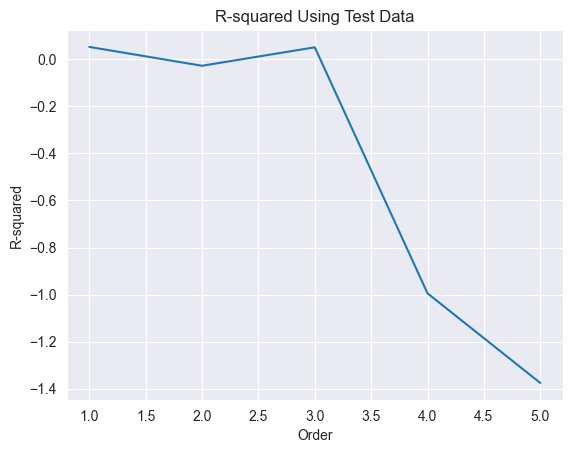

In [12]:
plt.plot(order, r_square_test)
plt.xlabel("Order")
plt.ylabel("R-squared")
plt.title("R-squared Using Test Data")

## Task 3 - Ridge Regression

<p>Now consider that you have multiple features such as <code>CPU_frequency</code>, <code>RAM_GB</code>, <code>Storage_GB_SSD</code>, <code>CPU_core</code>, <code>OS</code>, <code>GPU</code> and <code>Category</code>. Create a polynomial feature model that uses all these parameters with <code>degree=2</code>. Also create the training and testing attribute sets.</p>

In [13]:
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train[["CPU_frequency", "RAM_GB", "Storage_GB_SSD", "CPU_core", "OS", "GPU", "Category"]])
x_test_pr = pr.fit_transform(x_test[["CPU_frequency", "RAM_GB", "Storage_GB_SSD", "CPU_core", "OS", "GPU", "Category"]])

<p>Create a Ridge Regression and evaluate it using values of the hyperparameter alpha ranging from 0.001 to 1 with increments of 0.001. Create a list of all Ridge Regression $R^2$ scores for training and testing data.</p>

In [14]:
r_square_test = []
r_square_train = []
alpha = np.arange(0.001, 1, 0.001)
pbar = tqdm(alpha)

for a in pbar:
    ridge_model = Ridge(alpha=a)
    ridge_model.fit(x_train_pr, y_train)

    test_score = ridge_model.score(x_test_pr, y_test)
    train_score = ridge_model.score(x_train_pr, y_train)

    pbar.set_postfix({"Test score": test_score, "Train score": train_score})

    r_square_test.append(test_score)
    r_square_train.append(train_score)

100%|██████████| 999/999 [00:01<00:00, 638.57it/s, Test score=0.423, Train score=0.669]


<p>Plot the $R^2$ values for training and testing sets with respect to the value of alpha.</p>

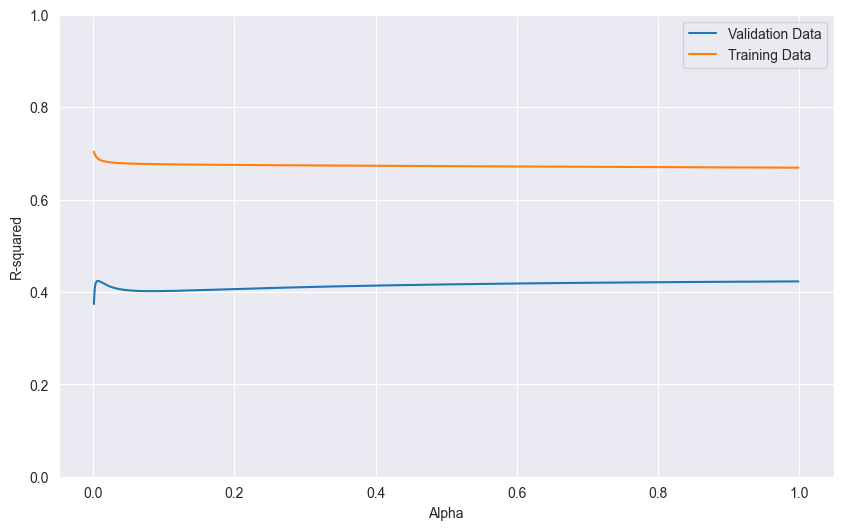

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(alpha, r_square_test, label="Validation Data")
plt.plot(alpha, r_square_train, label="Training Data")
plt.xlabel("Alpha")
plt.ylabel("R-squared")
plt.ylim(0, 1)
plt.legend()

## Task 4 - Grid Search

<p>Using the raw data and the same set of features as used above, use <code>GridSearchCV()</code> to identify the value of alpha for which the model performs best. Assume the set of alpha values to be used as:</p>
<pre>{0.0001, 0.001, 0.01, 0.1, 1, 10}</pre>

In [16]:
para1 = [{"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10]}]

<p>Create a Ridge instance and run Grid Search using a 4-fold cross validation.</p>

In [17]:
grid1 = GridSearchCV(Ridge(), para1, cv=4)

<p>Fit the Grid Search to the training data.</p>

In [18]:
grid1.fit(x_train[["CPU_frequency", "RAM_GB", "Storage_GB_SSD", "CPU_core", "OS", "GPU", "Category"]], y_train)

,estimator,Ridge()
,param_grid,"[{'alpha': [0.0001, 0.001, ...]}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,10


<p>Print the $R^2$ score for the test data using the estimator that uses the derived optimum value of alpha.</p>

In [19]:
best_est = grid1.best_estimator_
best_est.score(x_test[["CPU_frequency", "RAM_GB", "Storage_GB_SSD", "CPU_core", "OS", "GPU", "Category"]], y_test)

0.300990504869182

****
This is the end of the file.
****